In [1]:
using Revise

using RigidBodyDynamics
using RigidBodyDynamics: Bounds

using DrakeVisualizer
using Plots
using RigidBodyTreeInspector

using Bilevel
gr(size=(500,500), html_output_format=:png);

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= Bounds(-100, 100)
velocity_bounds(floatingjoint) .= Bounds(-100, 100)
μ = 0.5
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005;

In [20]:
# q0 = [1., 0., 0., 0., 0., 0., 0.005]
q0 = [1., 0., 0., 0., 0., 0., 0.0]
v0 = [0., 0., 0., 0.1, 0. , 0.]
N = 5

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

ctrl! = (u,t,x) -> u[:] = 0.

(::#25) (generic function with 1 method)

In [27]:
println("Explicit Contacts")
traj_exp = Bilevel.simulate_snopt(x0,env,Δt,N,ctrl!,implicit_contact=false);

Explicit Contacts
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied


In [29]:
println("Implicit Contacts")
traj_imp = Bilevel.simulate_snopt(x0,env,Δt,N,ctrl!,implicit_contact=true);

Implicit Contacts


elapsed time: 242.194557072 seconds
elapsed time: 0.866916012 seconds
elapsed time: 0.858684106 seconds
elapsed time: 0.858152469 seconds
elapsed time: 0.857327546 seconds
elapsed time: 0.856528031 seconds
elapsed time: 0.861651007 seconds
Finished successfully: optimality conditions satisfied
elapsed time: 0.851284877 seconds
elapsed time: 0.862713339 seconds
elapsed time: 0.857001768 seconds
elapsed time: 0.860078858 seconds
elapsed time: 1.083094022 seconds
elapsed time: 0.814887291 seconds
elapsed time: 0.815643414 seconds
elapsed time: 0.820084838 seconds
elapsed time: 0.817258943 seconds
elapsed time: 0.822417316 seconds
elapsed time: 0.815011776 seconds
elapsed time: 0.815959903 seconds
Finished successfully: optimality conditions satisfied
elapsed time: 0.82608247 seconds
elapsed time: 0.815445147 seconds
elapsed time: 0.816297251 seconds
elapsed time: 0.815451349 seconds
elapsed time: 0.817376295 seconds
elapsed time: 0.823814442 seconds
elapsed time: 0.812491881 seconds
elaps

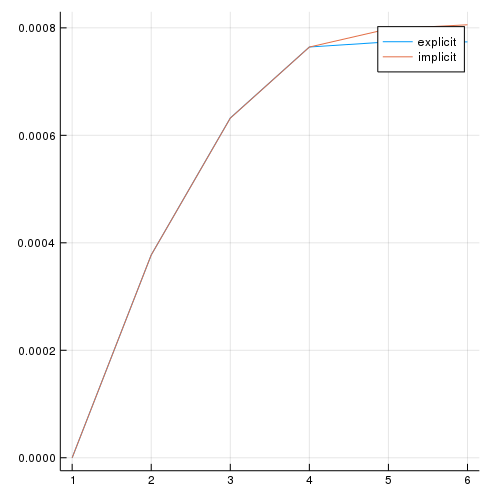

In [30]:
ts = cumsum([Δt for i in 1:N]);
j = 5
plot(traj_exp[j,:],label="explicit")
plot!(traj_imp[j,:],label="implicit")